# This file process a .nc file taked from AppEARS with data from MOD13Q1 (NDVI) and save it as a CSV.

## First we make explicit the installation of libraries we will use and the importing.

In [1]:
!pip3 install -q --upgrade pip
!pip3 install -q pandas numpy matplotlib seaborn openpyxl climateserv requests netCDF4 xarray pyproj

In [2]:
import os
import netCDF4 as nc
import numpy as np
import xarray as xr
import pandas as pd

## We create a code to know what is inside the file .nc, wich variables how many data, etc. 

In [5]:
def analyze_nasadem_file(file_path: str) -> None:
    """
    Analyze a NASADEM NetCDF file and print out its contents, such as variable names,
    dimensions, and min/max values for longitude and latitude.

    Args:
    file_path (str): The path to the NASADEM NetCDF file.
    """
    # Open the NetCDF file
    dataset = nc.Dataset(file_path, 'r')

    # Print general information about the file
    print('')
    print(f"Analyzing file: {file_path}")
    print("Variables in this file:")
    for var in dataset.variables:
        print(f" - {var}: {dataset.variables[var].dimensions}, {dataset.variables[var].shape}")

    # Check for common variables like longitude and latitude
    if 'lon' in dataset.variables and 'lat' in dataset.variables:
        lon = dataset.variables['lon'][:]
        lat = dataset.variables['lat'][:]
        print(f"Longitude range: {np.min(lon)} to {np.max(lon)}")
        print(f"Latitude range: {np.min(lat)} to {np.max(lat)}")
    
    # Close the dataset
    dataset.close()

# Paths to your files
file_paths = [
    '../../data/original_data/appears/ndvi/MOD13Q1.061_250m_aid0001.nc',
]

# Analyze each file
for path in file_paths:
    analyze_nasadem_file(file_path=path)


Analyzing file: ../../data/original_data/appears/ndvi/MOD13Q1.061_250m_aid0001.nc
Variables in this file:
 - crs: (), ()
 - time: ('time',), (185,)
 - ydim: ('ydim',), (467,)
 - xdim: ('xdim',), (1567,)
 - _250m_16_days_EVI: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_MIR_reflectance: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_NDVI: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_NIR_reflectance: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_VI_Quality: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_blue_reflectance: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_composite_day_of_the_year: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_pixel_reliability: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_red_reflectance: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_relative_azimuth_angle: ('time', 'ydim', 'xdim'), (185, 467, 1567)
 - _250m_16_days_sun_zenith_angle:

## After we know what its inside the file, we process him, converting into a DataFrame and saving as CSV.

In [ ]:
def nasadem_to_dataframe(file_path: str) -> pd.DataFrame:
    """
    Convert a NASADEM NetCDF file to a Pandas DataFrame, including the time variable.

    Args:
    file_path (str): The path to the NASADEM NetCDF file.

    Returns:
    pd.DataFrame: A DataFrame containing the extracted data.
    """
    with nc.Dataset(file_path, 'r') as dataset:
        # Extract longitude, latitude, and time arrays
        lon = dataset.variables['lon'][:]
        lat = dataset.variables['lat'][:]
        time = dataset.variables['time'][:]

        # Convert numeric time values to human-readable dates
        time_units = dataset.variables['time'].units
        time_calendar = dataset.variables['time'].calendar
        dates = nc.num2date(time, units=time_units, calendar=time_calendar)

        # Create a meshgrid for lon, lat, and time
        lon_grid, lat_grid, time_grid = np.meshgrid(lon, lat, dates, indexing='ij')

        # Flatten the grids
        lon_flat = lon_grid.flatten()
        lat_flat = lat_grid.flatten()
        time_flat = time_grid.flatten()

        # Initialize a dictionary to hold data
        data = {'Time': time_flat, 'Longitude': lon_flat, 'Latitude': lat_flat}

        # Add other variables to the dictionary
        for var in ['_250m_16_days_NDVI', '_250m_16_days_EVI']:
            if var in dataset.variables:
                # Extract, reshape to match time grid, and flatten
                var_data = dataset.variables[var][:]  # Includes the time dimension
                var_data_reshaped = var_data.reshape(var_data.shape[0], -1)  # Reshape for each time slice
                data[var] = var_data_reshaped.flatten()

        # Create a DataFrame from the dictionary
        df = pd.DataFrame(data)

    return df

def remove_nan_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove rows with NaN values in specific columns from the DataFrame.

    Args:
    df (pd.DataFrame): The original DataFrame.

    Returns:
    pd.DataFrame: A DataFrame with rows containing NaN values in specific columns removed.
    """
    return df.dropna(subset=['_250m_16_days_NDVI', '_250m_16_days_EVI'])


def save_dataframe_to_csv(df: pd.DataFrame, csv_path: str) -> None:
    """
    Save a Pandas DataFrame to a CSV file.

    Args:
    df (pd.DataFrame): The DataFrame to save.
    csv_path (str): The path where the CSV file will be saved.
    """
    df.to_csv(csv_path, index=False)
    print(f"DataFrame saved to {csv_path}")


# Paths to your files
file_paths = [
    '../../data/original_data/appears/ndvi/MOD13Q1.061_250m_aid0001.nc',
]

# Convert each file to a DataFrame, remove NaN rows, and analyze
for path in file_paths:
    df = nasadem_to_dataframe(file_path=path)
    df_no_nan = remove_nan_rows(df=df)
    df_no_nan  # Display the DataFrame

    # Derive CSV file name from NetCDF file name
    csv_path = '../../data/processed_data/appears/ndvi/ndvi_data.csv'

    # Save the DataFrame to CSV
    save_dataframe_to_csv(df=df, csv_path=csv_path)

In [14]:
df

,Time,Longitude,Latitude,_250m_16_days_NDVI,_250m_16_days_EVI
0,2014-12-19 00:00:00,-17.078125,13.873958,NaN,NaN
1,2015-01-01 00:00:00,-17.078125,13.873958,NaN,NaN
2,2015-01-17 00:00:00,-17.078125,13.873958,NaN,NaN
3,2015-02-02 00:00:00,-17.078125,13.873958,NaN,NaN
4,2015-02-18 00:00:00,-17.078125,13.873958,NaN,NaN
...,...,...,...,...,...
112588590,2022-10-16 00:00:00,-13.769792,13.078125,0.5130,0.2398
112588591,2022-11-01 00:00:00,-13.769792,13.078125,0.5775,0.2711
112588592,2022-11-17 00:00:00,-13.769792,13.078125,0.5775,0.2711
112588593,2022-12-03 00:00:00,-13.769792,13.078125,0.5792,0.2673


## Finally we see what its inside the file to check.

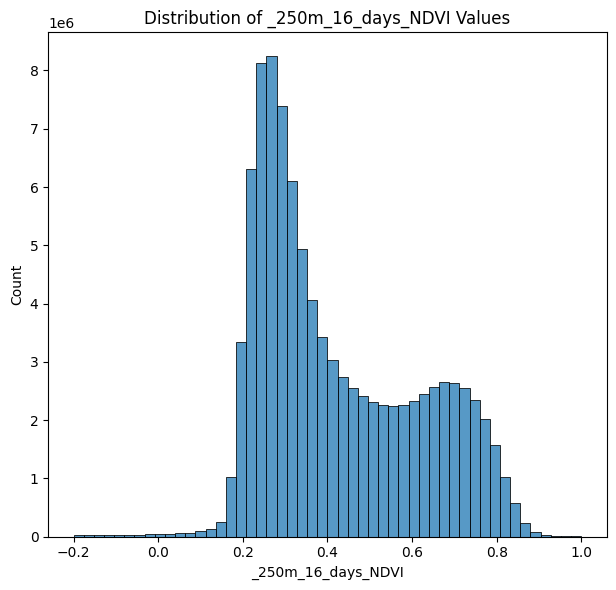

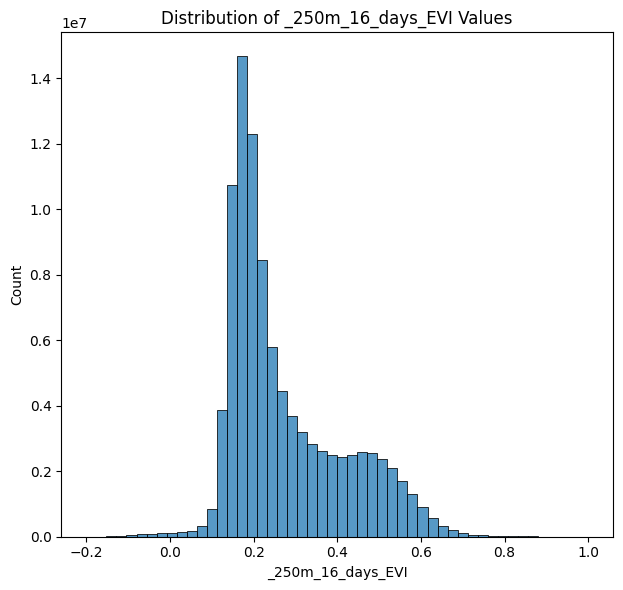

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_variable_distribution(df: pd.DataFrame, column_name: str) -> None:
    """
    Plots the distribution of values and NaN vs non-NaN counts for a specified column in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        column_name (str): The name of the column to plot.
    """
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 6))

    # Histogram of values excluding NaNs
    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name].dropna(), kde=False, bins=50)
    plt.title(f'Distribution of {column_name} Values')
    plt.xlabel(column_name)
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Call the function for each column
plot_variable_distribution(df=df, column_name='_250m_16_days_NDVI')
plot_variable_distribution(df=df, column_name='_250m_16_days_EVI')


In [ ]:
import pandas as pd

def load_csv_to_dataframe(file_path: str) -> pd.DataFrame:
    """
    Load a CSV file from the specified path and return it as a DataFrame.

    Args:
    file_path (str): The path to the CSV file.

    Returns:
    pd.DataFrame: DataFrame containing the contents of the CSV file.
    """
    return pd.read_csv(filepath_or_buffer=file_path)

# Example usage
csv_path = "../../data/processed_data/appears/ndvi/ndvi_data.csv"  # Replace with your CSV file path
df = load_csv_to_dataframe(file_path=csv_path)
print(df)


df

In [14]:
df

,Time,Longitude,Latitude,_250m_16_days_NDVI,_250m_16_days_EVI
0,2014-12-19 00:00:00,-17.078125,13.873958,NaN,NaN
1,2015-01-01 00:00:00,-17.078125,13.873958,NaN,NaN
2,2015-01-17 00:00:00,-17.078125,13.873958,NaN,NaN
3,2015-02-02 00:00:00,-17.078125,13.873958,NaN,NaN
4,2015-02-18 00:00:00,-17.078125,13.873958,NaN,NaN
...,...,...,...,...,...
112588590,2022-10-16 00:00:00,-13.769792,13.078125,0.5130,0.2398
112588591,2022-11-01 00:00:00,-13.769792,13.078125,0.5775,0.2711
112588592,2022-11-17 00:00:00,-13.769792,13.078125,0.5775,0.2711
112588593,2022-12-03 00:00:00,-13.769792,13.078125,0.5792,0.2673


In [ ]:
import pandas as pd
from typing import Tuple
from tqdm import tqdm

# This will enable the progress_apply method on pandas DataFrame/Series
tqdm.pandas()

def calculate_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the Euclidean distance between two latitude-longitude points.
    """
    return ((lat1 - lat2)**2 + (lon1 - lon2)**2)**0.5

def find_closest_point(df: pd.DataFrame, target_lat: float, target_lon: float) -> Tuple[float, float]:
    """
    Find the closest latitude and longitude in the DataFrame to the target latitude and longitude.
    """
    # Using progress_apply instead of apply to show the progress bar
    distances = df.progress_apply(lambda row: calculate_distance(row['Latitude'], row['Longitude'], target_lat, target_lon), axis=1)
    closest_index = distances.idxmin()
    closest_point = df.loc[closest_index, ['Latitude', 'Longitude']]
    return closest_point['Latitude'], closest_point['Longitude']

def filter_dataframe(df: pd.DataFrame, lat: float, lon: float) -> pd.DataFrame:
    """
    Filter the DataFrame for the rows matching the specified latitude and longitude.
    """
    return df[(df['Latitude'] == lat) & (df['Longitude'] == lon)]

# Example usage
# df is your original DataFrame
target_latitude = 13.4984817969726
target_longitude = -14.7573025092349

closest_lat, closest_lon = find_closest_point(df=df, target_lat=target_latitude, target_lon=target_longitude)
filtered_df = filter_dataframe(df=df, lat=closest_lat, lon=closest_lon)

filtered_df
